Consider the dataset invertebrate. It holds 280 records of flying nocturnal invertebrate (e.g., insects such as moths, beetles, mosquitos, etc.) biodiversity, based on 280 sampling events in 2017 in a province in France. The outcome of interest is the Shannon-Wiener index (SWI), which is a measure of biodiversity. Within the context of this project, it suffices to know that SWI is a non-negative metric that is usually in practice smaller than 4.5. Low values denote low diversity, while higher values denote higher diversity. In addition to SWI, a number of explanatory variables are collected as well. An overview of all variables in the data is given in the variable description table mentioned below.

The goal of this analysis is to build a model of SWI as a function of SWF, temperature, size, management, and, duration. You will build the model via the Invertebrate_Dataset and submit your predictions for the new_test data in the format mentioned under "Submission format" section.

In [1]:
!pip install catboost

     |████████████████████████████████| 66.1MB 55kB/s 


In [2]:
#import libraries 
import numpy as np
import pandas as pd
#import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
# libraries for machine learning
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
invertebrate_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Invertebrate/Invertebrate_dataset.csv')

In [4]:
invertebrate_data.columns

Index(['SWI', 'SWF', 'temperature', 'size', 'management', 'duration'], dtype='object')

Please find the variable description of the dataset variables below:

|Column Names|Description|
|:----|:----|
|SWI|The Shannon-Wiener index for (flying nocturnal) invertebrate diversity on the patch (non-negative, larger values denote higher diversity).|
|SWF|An (adjusted) Shannon-Wiener index for floristic diversity on the patch. The interpretation of this metric is the same as for SWI (non-negative, larger values denote higher diversity).|
|Temperature|Temperature at the sampling event (in degrees Celsius).|
|Size|The size of the sampling patch (in m2)|
|Management|The number of years that the patch has been subject to nature management|
|Duration|The duration of a sampling event (in minutes)|

In [5]:
invertebrate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SWI          280 non-null    float64
 1   SWF          280 non-null    float64
 2   temperature  280 non-null    float64
 3   size         280 non-null    float64
 4   management   280 non-null    int64  
 5   duration     280 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 13.2 KB


In [6]:
invertebrate_data.shape

(280, 6)

In [7]:
invertebrate_data.head()

,SWI,SWF,temperature,size,management,duration
0,0.59,1.30,3.5,0.5,2,20
1,1.21,1.85,4.6,47.2,3,19
2,1.08,0.97,4.8,53.3,4,22
3,1.60,1.67,5.2,27.2,8,20
4,2.95,2.41,5.7,38.8,6,22


In [8]:
invertebrate_data.describe()

,SWI,SWF,temperature,size,management,duration
count,280.000000,280.000000,280.000000,280.000000,280.000000,280.000000
mean,1.896714,1.480679,16.372500,41.138214,4.082143,31.307143
std,0.610995,0.476403,3.619312,19.434496,2.520959,4.198304
min,0.480000,0.250000,3.500000,0.500000,0.000000,19.000000
25%,1.507500,1.190000,14.100000,27.275000,2.000000,29.000000
50%,1.825000,1.495000,17.050000,41.100000,4.000000,32.000000
75%,2.282500,1.790000,19.125000,54.725000,6.000000,34.000000
max,3.790000,2.840000,21.600000,94.200000,8.000000,41.000000


In [9]:
invertebrate_data.corr()

,SWI,SWF,temperature,size,management,duration
SWI,1.000000,0.680071,0.254698,-0.016571,0.300495,0.214081
SWF,0.680071,1.000000,-0.065078,0.004630,0.077577,-0.093165
temperature,0.254698,-0.065078,1.000000,0.006262,-0.007137,0.874055
size,-0.016571,0.004630,0.006262,1.000000,0.020412,-0.043318
management,0.300495,0.077577,-0.007137,0.020412,1.000000,-0.017970
duration,0.214081,-0.093165,0.874055,-0.043318,-0.017970,1.000000


In [10]:
invertebrate_data.groupby('SWI').mean()

,SWF,temperature,size,management,duration
SWI,,,,,
0.48,0.71,9.3,31.6,0.0,22.0
0.54,0.64,15.6,19.5,0.0,32.0
0.59,1.30,3.5,0.5,2.0,20.0
0.63,0.58,18.8,69.8,2.0,32.0
0.68,1.07,16.8,7.1,0.0,34.0
...,...,...,...,...,...
3.38,2.39,19.7,54.6,6.0,35.0
3.44,2.42,14.8,27.1,7.0,29.0
3.58,2.51,14.6,47.9,8.0,26.0


In [11]:
invertebrate_data['SWI'].value_counts(bins = 7)

(1.426, 1.899]    93
(1.899, 2.371]    63
(0.953, 1.426]    48
(2.371, 2.844]    43
(2.844, 3.317]    17
(0.476, 0.953]    11
(3.317, 3.79]      5
Name: SWI, dtype: int64

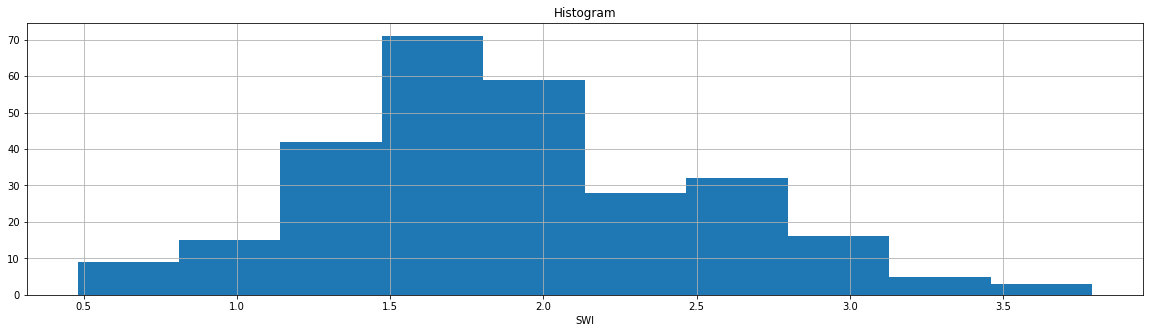

In [12]:
invertebrate_data['SWI'].hist(figsize=(20,5))
plt.xlabel('SWI')
plt.title('Histogram');

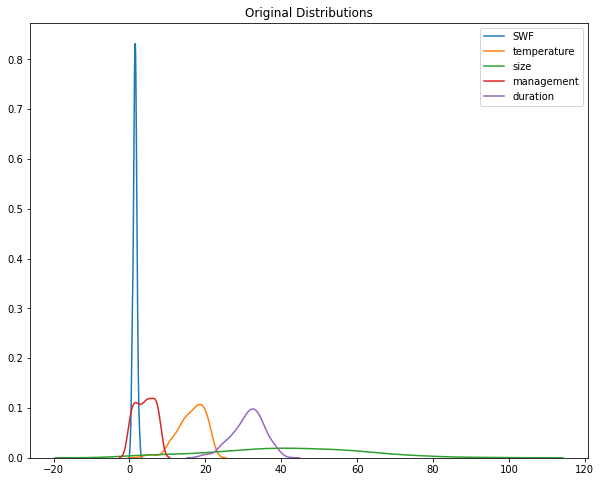

In [13]:
# plot original distribution plot
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

#sns.kdeplot(invertebrate_data['SWI'], ax=ax1)
sns.kdeplot(invertebrate_data['SWF'], ax=ax1)
sns.kdeplot(invertebrate_data['temperature'], ax=ax1)
sns.kdeplot(invertebrate_data['size'], ax=ax1)
sns.kdeplot(invertebrate_data['management'], ax=ax1);
sns.kdeplot(invertebrate_data['duration'], ax=ax1);


In [14]:
minmax_invertebratedata = invertebrate_data.drop('SWI', axis = 1)
col_name = invertebrate_data.drop(['SWI'], axis = 1).columns[:]
#print(invertebrate_data.head())
#print(minmax_invertebratedata[:5])
minmax_scaler = preprocessing.MinMaxScaler()
minmax_invertebratedata = minmax_scaler.fit_transform(minmax_invertebratedata)
minmax_invertebratedata = pd.DataFrame(minmax_invertebratedata, columns = col_name)
minmax_invertebratedata['SWI'] = invertebrate_data['SWI']
minmax_invertebratedata.head()

,SWF,temperature,size,management,duration,SWI
0,0.405405,0.000000,0.000000,0.250,0.045455,0.59
1,0.617761,0.060773,0.498399,0.375,0.000000,1.21
2,0.277992,0.071823,0.563501,0.500,0.136364,1.08
3,0.548263,0.093923,0.284952,1.000,0.045455,1.60
4,0.833977,0.121547,0.408751,0.750,0.136364,2.95


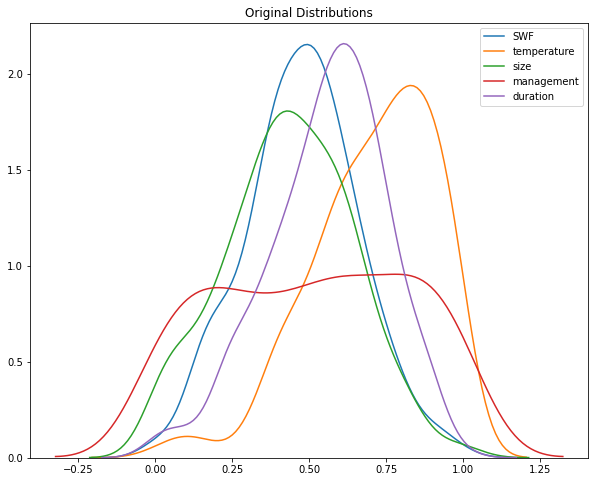

In [15]:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Original Distributions')

#sns.kdeplot(invertebrate_data['SWI'], ax=ax1)
sns.kdeplot(minmax_invertebratedata['SWF'], ax=ax1)
sns.kdeplot(minmax_invertebratedata['temperature'], ax=ax1)
sns.kdeplot(minmax_invertebratedata['size'], ax=ax1)
sns.kdeplot(minmax_invertebratedata['management'], ax=ax1);
sns.kdeplot(minmax_invertebratedata['duration'], ax=ax1);

In [16]:
minmax_invertebratedata.corr()

,SWF,temperature,size,management,duration,SWI
SWF,1.000000,-0.065078,0.004630,0.077577,-0.093165,0.680071
temperature,-0.065078,1.000000,0.006262,-0.007137,0.874055,0.254698
size,0.004630,0.006262,1.000000,0.020412,-0.043318,-0.016571
management,0.077577,-0.007137,0.020412,1.000000,-0.017970,0.300495
duration,-0.093165,0.874055,-0.043318,-0.017970,1.000000,0.214081
SWI,0.680071,0.254698,-0.016571,0.300495,0.214081,1.000000


In [17]:
# split data into input feature X and target variable y
X = minmax_invertebratedata.drop(['SWI'], axis = 1)
y = minmax_invertebratedata['SWI']

# split input feature X and target variable y in train and test set with 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [18]:
# model linear regression
lr = LinearRegression()
# Train the model on the training dataset
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
pred = lr.predict(X_test)

In [20]:
lr.score(X_test, y_test)

0.5689503442903747

In [21]:
r2_score(y_test, pred)

0.5689503442903747

In [22]:
#evaluating the performance of the model
#MAE
print(mean_absolute_error(y_test, pred), end='\n')
#MSE
print(mean_squared_error(y_test, pred), end='\n')
#RMSE
print(np.sqrt(mean_squared_error(y_test, pred)))

0.2987355434848616
0.15269100177691422
0.39075695998524995


In [23]:
test_new = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/Invertebrate/Invertebrate_new_test_data.csv')

In [24]:
test_new.shape

(120, 5)

In [25]:
test_new.head()

,SWF,temperature,size,management,duration
0,0.86,21.6,21.6,5,32
1,1.30,21.6,23.7,4,35
2,1.79,21.7,32.9,3,39
3,1.92,21.8,47.5,7,34
4,0.90,21.8,42.8,6,35


In [26]:
minmax_testnew = minmax_scaler.fit_transform(test_new)

In [27]:
minmax_testnew

array([[0.24313725, 0.        , 0.20547945, 0.625     , 0.47826087],
       [0.41568627, 0.        , 0.22760801, 0.5       , 0.60869565],
       [0.60784314, 0.00833333, 0.32455216, 0.375     , 0.7826087 ],
       [0.65882353, 0.01666667, 0.47839831, 0.875     , 0.56521739],
       [0.25882353, 0.01666667, 0.4288725 , 0.75      , 0.60869565],
       [0.8627451 , 0.01666667, 0.60168599, 0.875     , 0.73913043],
       [0.62352941, 0.01666667, 0.57955743, 0.375     , 0.73913043],
       [0.52156863, 0.01666667, 0.32876712, 0.625     , 0.69565217],
       [0.40784314, 0.01666667, 0.2739726 , 0.375     , 0.7826087 ],
       [0.45098039, 0.03333333, 0.43519494, 0.25      , 0.69565217],
       [0.68627451, 0.04166667, 0.18967334, 0.125     , 0.73913043],
       [0.56078431, 0.04166667, 0.57534247, 0.25      , 0.69565217],
       [0.40392157, 0.04166667, 0.13593256, 0.125     , 0.91304348],
       [0.74901961, 0.04166667, 0.29926238, 0.875     , 0.7826087 ],
       [0.36862745, 0.04166667, 0.

In [28]:
unknownswi = lr.predict(minmax_testnew)

In [29]:
res = pd.DataFrame(unknownswi)
res.index = test_new.index # its important for comparison
res.columns = ["SWI"]
res.to_csv("SWI_prediction_results_7030.csv")      

In [30]:
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
unknownswi_a = lr.predict(minmax_testnew)

In [32]:
res = pd.DataFrame(unknownswi_a)
res.index = test_new.index # its important for comparison
res.columns = ["SWI"]
res.to_csv("SWI_prediction_results_7030A.csv")
from google.colab import files     
files.download('SWI_prediction_results_7030A.csv')      

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
my_alpha = 0.1
my_model = Ridge(alpha = my_alpha)
my_model.fit(X, y)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [34]:
unknownswi_b = lr.predict(minmax_testnew)

In [35]:
res = pd.DataFrame(unknownswi_a)
res.index = test_new.index # its important for comparison
res.columns = ["SWI"]
res.to_csv("SWI_prediction_results_7030B.csv") 
from google.colab import files     
files.download('SWI_prediction_results_7030B.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
rfg = RandomForestRegressor(random_state = 5)
param_grid = param_grid = {
    'n_estimators': [100, 200, 300, 1000]
}
gs = GridSearchCV(estimator = rfg, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [37]:
gs.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   16.2s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=5,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

In [38]:
gs.best_params_

{'n_estimators': 1000}

In [39]:
unknownswi_c = gs.predict(minmax_testnew)

In [40]:
res = pd.DataFrame(unknownswi_c)
res.index = test_new.index # its important for comparison
res.columns = ["SWI"]
res.to_csv("SWI_prediction_results_7030C.csv") 
from google.colab import files     
files.download('SWI_prediction_results_7030C.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
newmodel = CatBoostRegressor(random_seed = 42 )
newparameters = {'depth'         : [6, 8, 10, 21, 53, 75,100, 200, 250],
                  'learning_rate' : [0.01, 0.05, 0.1],
                  'iterations'    : [30, 50, 100]
              }
newgrid = GridSearchCV(estimator=newmodel, param_grid = newparameters, cv = 2, n_jobs=-1)
newgrid.fit(X, y)

0:	learn: 0.5837711	total: 49.3ms	remaining: 2.42s
1:	learn: 0.5607330	total: 51.1ms	remaining: 1.23s
2:	learn: 0.5421193	total: 52.5ms	remaining: 823ms
3:	learn: 0.5213433	total: 53.7ms	remaining: 618ms
4:	learn: 0.5015718	total: 55ms	remaining: 495ms
5:	learn: 0.4870841	total: 56.2ms	remaining: 412ms
6:	learn: 0.4744990	total: 57.3ms	remaining: 352ms
7:	learn: 0.4603445	total: 58.3ms	remaining: 306ms
8:	learn: 0.4481116	total: 60.8ms	remaining: 277ms
9:	learn: 0.4379646	total: 63.9ms	remaining: 256ms
10:	learn: 0.4269909	total: 67.1ms	remaining: 238ms
11:	learn: 0.4173598	total: 69.3ms	remaining: 219ms
12:	learn: 0.4083445	total: 71.1ms	remaining: 202ms
13:	learn: 0.4004566	total: 72.7ms	remaining: 187ms
14:	learn: 0.3920554	total: 74.4ms	remaining: 174ms
15:	learn: 0.3859580	total: 75.8ms	remaining: 161ms
16:	learn: 0.3799143	total: 77ms	remaining: 149ms
17:	learn: 0.3753020	total: 78.2ms	remaining: 139ms
18:	learn: 0.3705058	total: 79.4ms	remaining: 129ms
19:	learn: 0.3645182	total

GridSearchCV(cv=2, error_score=nan,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f157b4aaa58>,
             iid='deprecated', n_jobs=-1,
             param_grid={'depth': [6, 8, 10, 21, 53, 75, 100, 200, 250],
                         'iterations': [30, 50, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [43]:
unknownswi_d = newgrid.predict(minmax_testnew)

In [44]:
res = pd.DataFrame(unknownswi_d)
res.index = test_new.index # its important for comparison
res.columns = ["SWI"]
res.to_csv("SWI_prediction_results_7030d.csv") 
from google.colab import files     
files.download('SWI_prediction_results_7030d.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>